In [1]:
%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader
#from networks import transform_network_utils

sys.path.append('../neuron')
sys.path.append('../voxelmorph')
import src.networks as vm_networks

sys.path.append('../voxelmorph-sandbox/')
from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer


gpu_ids = [3]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))


start_iter = 0
nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 32, 16, 16]
# vm2 model
voxelmorph_model = vm_networks.cvpr2018_net(
    vol_size=(160, 192, 224),
    enc_nf=nf_enc, 
    dec_nf=nf_dec,
    indexing='xy',
)

# # reset weights to random
# from keras.initializers import glorot_uniform
# session = K.get_session()
# initial_weights = voxelmorph_model.get_weights()
# new_weights = [glorot_uniform()(w.shape).eval(session=session) for w in initial_weights]
# voxelmorph_model.set_weights(new_weights)


Using TensorFlow backend.
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


Load training dataset

In [2]:
dataset_key = 'adni-10-csts2'
import vte_runner
data_params = vte_runner.named_vte_data_params[dataset_key]
    
ds = adni_loader.ADNIDataset(data_params)

vol_shape = tuple(data_params['img_shape'])

# just load some examples so we can get the image size, but actually use a generator later...
(X_unlabeled, _, ids_unlabeled),\
(X_labeled_train, Y_labeled_train, ids_labeled_train), \
(X_labeled_valid, Y_labeled_valid, ids_labeled_valid), \
label_mapping \
= ds.load_dataset(debug=False)

../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Loading adni dataset adni-unnorm-masked_10ul_subj-OASIS_OAS1_0327-l
Params: {'dataset_name': 'adni', 'source_name': 'atl', 'target_name': 'subjs', 'unnormalized': True, 'masked': True, 'n_shot': 1, 'use_atlas_as_source': False, 'use_subject': 'OASIS_OAS1_0327_MR1_mri_talairach_orig', 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 10, 'n_validation': 50, 'load_vols': True, 'aug_in_gen': True, 'n_vte_aug': None, 'n_flow_aug': None, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'warp_labels': True, 'n_dims': 3, 'orig_img_shape': (160, 192, 224, 1), 'scale': 1.0, 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_S_1326_base_mri

(11, 160, 192, 224, 1)
(1, 160, 192, 224, 1)
(50, 160, 192, 224, 1)
['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz']
True


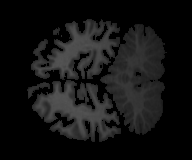

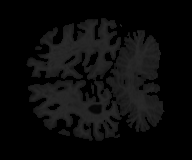

In [3]:
print(X_unlabeled.shape)
print(X_labeled_train.shape)
print(X_labeled_valid.shape)
print(ds.files_labeled_train)
print(ds.params['load_vols'])
import IPython
import PIL
IPython.display.display(PIL.Image.fromarray((X_labeled_train[0, :, :, 64, 0]*255).astype(np.uint8)))
IPython.display.display(PIL.Image.fromarray((X_unlabeled[0, :, :, 64, 0]*255).astype(np.uint8)))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 160, 192, 224 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 112,  880         concatenate_1[0][0]              
__________

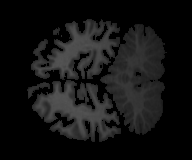

In [4]:
voxelmorph_model.summary()
import data_utils
sys.path.append('../voxelmorph')
import src.losses as vm_losses
# just train voxelmorph
voxelmorph_model.compile(
    #loss=['mean_squared_error', vm_losses.gradientLoss('l2')],
    loss=[vm_losses.NCC().loss, vm_losses.Grad('l2').loss],
    #loss_weights=[1.0, ,0.01],
    loss_weights=[1.0, 1.],#0.01],
    optimizer=Adam(0.0001)
)

#source_X = ds.X_atlas
source_X, _ = adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
source_X = source_X[np.newaxis]
IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))



In [ ]:
n_train_iters = 50000
vol_gen = ds.gen_vols_batch(['labeled_train', 'unlabeled_train'], batch_size=1, randomize=True)
print(ds.files_labeled_train + ds.files_unlabeled_train)
#vol_gen = data_utils.gen_batch(X_unlabeled, X_unlabeled, batch_size=1, randomize=True)
target_X, _ = next(vol_gen)
zeros_flow = np.zeros(target_X.shape[:-1] + (3,))

for bi in range(n_train_iters + 1):
    
    target_X, _ = next(vol_gen)
    
    # subject-to-atlas training
    vm_losses = voxelmorph_model.train_on_batch([source_X, target_X], [target_X, zeros_flow])
    #[source_X, target_X], [target_X, zeros_flow])
    print('Iter {}, loss {}'.format(bi, vm_losses))
    
    if bi > 0 and bi % 2000 == 0:
        voxelmorph_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_10-ul_xy_iter{}.h5'.format(start_iter + bi))

['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_263697.long.153_S_4077_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_223532.long.153_S_2109_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_76615.long.021_S_0984_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_451346.long.009_S_0751_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100329_NW33DK_FS_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_282668.long.002_S_4270_base_mri_talairach_orig.npz', '/data/ddmg/voxelmor

Iter 116, loss [-0.04621752, -0.04624444, 2.69207e-05]
Iter 117, loss [-0.060568064, -0.06059159, 2.3525685e-05]
Iter 118, loss [-0.046584573, -0.04661817, 3.3598586e-05]
Iter 119, loss [-0.06109863, -0.06112726, 2.8630157e-05]
Iter 120, loss [-0.047978435, -0.048019946, 4.1509276e-05]
Iter 121, loss [-0.047117334, -0.047169417, 5.2081956e-05]
Iter 122, loss [-0.047380626, -0.047438182, 5.755618e-05]
Iter 123, loss [-0.056577254, -0.05663699, 5.9735277e-05]
Iter 124, loss [-0.28892642, -0.28895748, 3.1066942e-05]
Iter 125, loss [-0.047978364, -0.048024587, 4.6223864e-05]
Iter 126, loss [-0.059170175, -0.05919836, 2.8185277e-05]
Iter 127, loss [-0.31015456, -0.3101682, 1.3643874e-05]
Iter 128, loss [-0.3139162, -0.3139265, 1.0274991e-05]
Iter 129, loss [-0.05092862, -0.050940596, 1.1978509e-05]
Iter 130, loss [-0.056865968, -0.056877185, 1.1215753e-05]
Iter 131, loss [-0.039417822, -0.039422836, 5.01239e-06]
Iter 132, loss [-0.03916646, -0.039170597, 4.134994e-06]
Iter 133, loss [-0.055

Iter 259, loss [-0.048068643, -0.048119143, 5.0501763e-05]
Iter 260, loss [-0.05958553, -0.059645236, 5.9706406e-05]
Iter 261, loss [-0.05980933, -0.05987408, 6.474943e-05]
Iter 262, loss [-0.056751803, -0.056807008, 5.5206674e-05]
Iter 263, loss [-0.06232899, -0.06236475, 3.575731e-05]
Iter 264, loss [-0.05916359, -0.059256513, 9.29229e-05]
Iter 265, loss [-0.057143494, -0.057223946, 8.045159e-05]
Iter 266, loss [-0.057165742, -0.057256345, 9.060455e-05]
Iter 267, loss [-0.047058992, -0.047188424, 0.00012943053]
Iter 268, loss [-0.052920442, -0.05306864, 0.00014819884]
Iter 269, loss [-0.06347386, -0.063538566, 6.470579e-05]
Iter 270, loss [-0.04731286, -0.047458913, 0.00014605394]
Iter 271, loss [-0.053350907, -0.053493425, 0.00014251695]
Iter 272, loss [-0.062224057, -0.06239061, 0.00016655444]
Iter 273, loss [-0.062256392, -0.06243088, 0.0001744881]
Iter 274, loss [-0.31257355, -0.31259325, 1.9692707e-05]
Iter 275, loss [-0.04731792, -0.04744891, 0.00013099238]
Iter 276, loss [-0.0

Iter 402, loss [-0.04947669, -0.049913883, 0.00043719186]
Iter 403, loss [-0.05680263, -0.05716449, 0.00036186035]
Iter 404, loss [-0.04323531, -0.043605972, 0.00037066377]
Iter 405, loss [-0.050388932, -0.050827604, 0.00043867325]
Iter 406, loss [-0.061206967, -0.06159549, 0.00038852356]
Iter 407, loss [-0.055109043, -0.055522352, 0.00041330897]
Iter 408, loss [-0.050670475, -0.051170625, 0.0005001488]
Iter 409, loss [-0.04953502, -0.05026716, 0.0007321404]
Iter 410, loss [-0.049671, -0.050454956, 0.00078395556]
Iter 411, loss [-0.050285663, -0.050961163, 0.00067549845]
Iter 412, loss [-0.061389558, -0.062272068, 0.00088251167]
Iter 413, loss [-0.05567187, -0.056346394, 0.00067452376]
Iter 414, loss [-0.057314545, -0.058037024, 0.0007224788]
Iter 415, loss [-0.06269222, -0.06334876, 0.0006565474]
Iter 416, loss [-0.062797666, -0.06347706, 0.0006793991]
Iter 417, loss [-0.064480804, -0.06554464, 0.0010638412]
Iter 418, loss [-0.06173121, -0.06288018, 0.0011489701]
Iter 419, loss [-0.05

Iter 548, loss [-0.08150231, -0.087550744, 0.0060484363]
Iter 549, loss [-0.07619701, -0.08429304, 0.008096021]
Iter 550, loss [-0.2954778, -0.2966872, 0.0012093913]
Iter 551, loss [-0.078365475, -0.0851086, 0.006743122]
Iter 552, loss [-0.07299124, -0.08151415, 0.008522909]
Iter 553, loss [-0.2936936, -0.29474905, 0.0010554439]
Iter 554, loss [-0.07476813, -0.08019084, 0.0054227016]
Iter 555, loss [-0.073968254, -0.079678684, 0.00571043]
Iter 556, loss [-0.06257949, -0.06754559, 0.0049661016]
Iter 557, loss [-0.06689932, -0.07098915, 0.004089823]
Iter 558, loss [-0.07161385, -0.07535604, 0.0037421915]
Iter 559, loss [-0.06038212, -0.06516476, 0.0047826404]
Iter 560, loss [-0.07240985, -0.07615143, 0.0037415796]
Iter 561, loss [-0.0663173, -0.071192235, 0.0048749344]
Iter 562, loss [-0.06695212, -0.07205992, 0.005107805]
Iter 563, loss [-0.07396431, -0.07937825, 0.0054139383]
Iter 564, loss [-0.061846387, -0.06818708, 0.006340695]
Iter 565, loss [-0.07381536, -0.07846372, 0.0046483586]

Iter 696, loss [-0.08913889, -0.102626964, 0.013488077]
Iter 697, loss [-0.08839189, -0.10240046, 0.014008565]
Iter 698, loss [-0.080583304, -0.09207467, 0.011491366]
Iter 699, loss [-0.07562286, -0.09401487, 0.018392015]
Iter 700, loss [-0.09609714, -0.10688532, 0.010788178]
Iter 701, loss [-0.0865033, -0.09861178, 0.012108481]
Iter 702, loss [-0.077743314, -0.09308074, 0.0153374225]
Iter 703, loss [-0.086566046, -0.09995664, 0.013390595]
Iter 704, loss [-0.09091539, -0.10389634, 0.012980951]
Iter 705, loss [-0.092267044, -0.105260886, 0.012993845]
Iter 706, loss [-0.085793756, -0.10086415, 0.0150703965]
Iter 707, loss [-0.06436834, -0.076425925, 0.012057586]
Iter 708, loss [-0.092536554, -0.10701578, 0.014479224]
Iter 709, loss [-0.090155296, -0.10484928, 0.014693982]
Iter 710, loss [-0.0691376, -0.082982756, 0.013845153]
Iter 711, loss [-0.09284119, -0.10364457, 0.010803378]
Iter 712, loss [-0.06624688, -0.078160755, 0.011913873]
Iter 713, loss [-0.09773873, -0.10887713, 0.011138402

Iter 845, loss [-0.092446074, -0.11022208, 0.017776003]
Iter 846, loss [-0.10542384, -0.12684393, 0.02142009]
Iter 847, loss [-0.10601714, -0.12708898, 0.021071833]
Iter 848, loss [-0.09227741, -0.11790379, 0.025626387]
Iter 849, loss [-0.092414126, -0.11751995, 0.02510583]
Iter 850, loss [-0.07423914, -0.090557806, 0.016318662]
Iter 851, loss [-0.10593103, -0.12199457, 0.016063537]
Iter 852, loss [-0.10669678, -0.123233326, 0.016536549]
Iter 853, loss [-0.11146757, -0.1272421, 0.015774531]
Iter 854, loss [-0.07717404, -0.0956734, 0.018499356]
Iter 855, loss [-0.10294616, -0.12229294, 0.01934678]
Iter 856, loss [-0.30278268, -0.3049746, 0.002191913]
Iter 857, loss [-0.11274003, -0.13269787, 0.019957831]
Iter 858, loss [-0.09605554, -0.11754025, 0.021484714]
Iter 859, loss [-0.10210642, -0.11916488, 0.017058456]
Iter 860, loss [-0.07716179, -0.095093444, 0.017931659]
Iter 861, loss [-0.30733287, -0.30880192, 0.0014690583]
Iter 862, loss [-0.109271, -0.1295663, 0.0202953]
Iter 863, loss 

Iter 995, loss [-0.1066549, -0.12899417, 0.022339273]
Iter 996, loss [-0.12090537, -0.14825946, 0.02735409]
Iter 997, loss [-0.12766084, -0.14918517, 0.02152433]
Iter 998, loss [-0.106088124, -0.13853201, 0.03244389]
Iter 999, loss [-0.11594364, -0.13414566, 0.01820202]
Iter 1000, loss [-0.305537, -0.30831754, 0.002780564]
Iter 1001, loss [-0.107177936, -0.12786978, 0.02069185]
Iter 1002, loss [-0.10689409, -0.13697, 0.030075911]
Iter 1003, loss [-0.12011302, -0.13897865, 0.01886562]
Iter 1004, loss [-0.10755235, -0.13669397, 0.029141616]
Iter 1005, loss [-0.12838604, -0.1482994, 0.019913359]
Iter 1006, loss [-0.10828038, -0.1288271, 0.020546714]
Iter 1007, loss [-0.10888438, -0.13015974, 0.021275356]
Iter 1008, loss [-0.12138948, -0.14478514, 0.023395656]
Iter 1009, loss [-0.12996621, -0.15273091, 0.022764694]
Iter 1010, loss [-0.108541265, -0.14232719, 0.033785928]
Iter 1011, loss [-0.122372895, -0.14759265, 0.025219752]
Iter 1012, loss [-0.12806284, -0.14915986, 0.021097017]
Iter 10

Iter 1142, loss [-0.13721602, -0.15914546, 0.02192944]
Iter 1143, loss [-0.1257019, -0.14552848, 0.019826574]
Iter 1144, loss [-0.11789619, -0.1417777, 0.023881502]
Iter 1145, loss [-0.12704355, -0.1579306, 0.030887058]
Iter 1146, loss [-0.13192788, -0.15554745, 0.023619583]
Iter 1147, loss [-0.13945796, -0.16491215, 0.02545419]
Iter 1148, loss [-0.13213152, -0.16100435, 0.028872833]
Iter 1149, loss [-0.097515166, -0.123331726, 0.02581656]
Iter 1150, loss [-0.1390765, -0.1668927, 0.027816214]
Iter 1151, loss [-0.11865227, -0.14721125, 0.028558984]
Iter 1152, loss [-0.11906934, -0.14729613, 0.028226793]
Iter 1153, loss [-0.121035025, -0.15103064, 0.029995618]
Iter 1154, loss [-0.12895024, -0.15381007, 0.024859827]
Iter 1155, loss [-0.11896956, -0.15563263, 0.03666307]
Iter 1156, loss [-0.12804857, -0.15080637, 0.022757804]
Iter 1157, loss [-0.140553, -0.16614024, 0.025587242]
Iter 1158, loss [-0.12907295, -0.15342455, 0.024351595]
Iter 1159, loss [-0.31521165, -0.3164863, 0.0012746342]


Iter 1289, loss [-0.12603293, -0.15556784, 0.029534904]
Iter 1290, loss [-0.13323054, -0.15847203, 0.025241492]
Iter 1291, loss [-0.13776734, -0.16359714, 0.025829798]
Iter 1292, loss [-0.104096144, -0.13160308, 0.027506933]
Iter 1293, loss [-0.12422089, -0.16334718, 0.039126292]
Iter 1294, loss [-0.3191069, -0.3196459, 0.0005390008]
Iter 1295, loss [-0.13361077, -0.15927683, 0.025666064]
Iter 1296, loss [-0.12361049, -0.15207718, 0.028466694]
Iter 1297, loss [-0.13478222, -0.16251858, 0.02773635]
Iter 1298, loss [-0.14524202, -0.17316917, 0.027927145]
Iter 1299, loss [-0.10433386, -0.13222432, 0.027890462]
Iter 1300, loss [-0.13498294, -0.16350733, 0.02852438]
Iter 1301, loss [-0.1352529, -0.1641404, 0.028887516]
Iter 1302, loss [-0.13426626, -0.16056037, 0.02629411]
Iter 1303, loss [-0.14386773, -0.16863312, 0.02476538]
Iter 1304, loss [-0.1050572, -0.13372964, 0.028672434]
Iter 1305, loss [-0.123822376, -0.15249665, 0.028674271]
Iter 1306, loss [-0.14593309, -0.1737976, 0.027864523]

Iter 1437, loss [-0.15061817, -0.1770863, 0.026468124]
Iter 1438, loss [-0.32048604, -0.32076523, 0.0002791974]
Iter 1439, loss [-0.13080955, -0.16729543, 0.03648588]
Iter 1440, loss [-0.13801265, -0.1627938, 0.02478115]
Iter 1441, loss [-0.109022796, -0.13807265, 0.029049857]
Iter 1442, loss [-0.109313026, -0.13921367, 0.029900637]
Iter 1443, loss [-0.32076836, -0.3210147, 0.00024635068]
Iter 1444, loss [-0.13904071, -0.16859603, 0.029555324]
Iter 1445, loss [-0.32084346, -0.3210832, 0.00023973276]
Iter 1446, loss [-0.12983549, -0.17029148, 0.040456004]
Iter 1447, loss [-0.12737143, -0.15683192, 0.029460488]
Iter 1448, loss [-0.13943133, -0.16500074, 0.025569405]
Iter 1449, loss [-0.13546485, -0.1572909, 0.021826064]
Iter 1450, loss [-0.12797163, -0.15540753, 0.027435904]
Iter 1451, loss [-0.13901462, -0.16622521, 0.027210599]
Iter 1452, loss [-0.13883263, -0.16756257, 0.028729944]
Iter 1453, loss [-0.13005821, -0.17100318, 0.040944964]
Iter 1454, loss [-0.14377528, -0.17033288, 0.026

In [ ]:
IPython.display.display(PIL.Image.fromarray(source_X[0, :, :, 112, :]))
IPython.display.display(PIL.Image.fromarray(target_X[0, :, :, 112, :]))
preds = voxelmorph_model.predict([source_X, target_X])
IPython.display.display(PIL.Image.fromarray(target_X[0, :, :, 112, :]))


In [ ]:
# we only need a wrapper if we trained the old voxelmorph with ji indexing in the spatial transformer
# # save a voxelmorph wrapper

# from keras.layers import Input, Lambda
# from keras.models import Model, load_model
# import sys
# sys.path.append('../voxelmorph/src')
# from dense_3D_spatial_transformer import Dense3DSpatialTransformer



# import os
# import tensorflow as tf
# import keras.backend as K
# gpu_ids = [2]
# # set gpu id and tf settings
# os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# K.tensorflow_backend.set_session(tf.Session(config=config))



# voxelmorph_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_iter100000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': Dense3DSpatialTransformer},
#     compile=False,
# )

# vol_shape = (160, 224, 192, 1)
# input_src = Input(vol_shape)
# input_tgt = Input(vol_shape)

# warped, flow = voxelmorph_model([input_src, input_tgt])
# flow = Lambda(lambda x:tf.gather(x, [1, 0, 2], axis=-1))(flow)  # reverse rows, cols

# wrapper_model = Model(inputs=[input_src, input_tgt], outputs=[flow, warped], name='vm2_cc_wrapper')
# wrapper_model.summary()
# wrapper_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_iter100000_wrapper.h5')